# debug RF SHAP

In [1]:
#!/usr/bin/env python
# coding: utf-8

import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit
import yaml
import pickle as pkl


from src.data_preparation import mdl_dataset

from src.modelling import model_ridge
from src.modelling import model_rf
from src.modelling import model_grdbst
from src.modelling import model_xgboost
# from src.modelling import super_model_ml

from src.modelling import mdl_input_dico  # input variables class
from src.modelling import mdl_params  # parameters class
from src.modelling import mdl_history

from src.visualization import visualize_pca
from src.visualization.time_serie_split import PlotTimeSerieSplit
from src.visualization import visu_mdl_importance
from src.visualization import mdl_scatter_pred as msp
from src.visualization import mdl_non_recursive
from src.visualization import mdl_recursive
from src.visualization import mdl_recursive_sequence
from src.visualization import mdl_permu_test
from src.visualization import mdl_introspect

from src.visualization import mdl_ypred_PCA

from src.utils import reload_config
from src.utils import tardisml_utils

KeyboardInterrupt: 

In [ ]:
# add argument to pass config file
import sys
narg = len(sys.argv)  # number of arguments passed

file_config = '../config/config_to_jobs/config_RF_no_bias_0wk_Hneg.yaml'

rootdir = tardisml_utils.get_rootdir()
# file_config = '../config/data_proc_full.yaml'
conf = reload_config.Config(file_config, rootdir=rootdir, verbose=1)

# import pdb; pdb.set_trace()
# ---------------------------------------------------
#                 Loading data
# ---------------------------------------------------

ds = mdl_dataset.Dataset(conf, setup=conf.setup, invert_t=conf.invert_time, return_raw=conf.return_raw)  # 'no_bias'  / default

#ds = mdl_dataset.Dataset(conf, setup='default', invert_t=True)  # 'no_bias'  / default
ds.print_charac()

# splitting the dataset for GridSearch
# put in class mdl_dataset (?)

nsplit = conf.nsplit  # 4
max_test_size = int(ds.dataset['Xtrain'].shape[0]/(nsplit +1))

ts_cv = TimeSeriesSplit(
    n_splits=nsplit,
    gap=0,
    max_train_size=ds.ntrain,
   test_size=max_test_size,
)


PlotTimeSerieSplit(ts_cv, ds.dataset['Xtrain'], ds.dataset['chrono_train'], rootdir+ds.config.fig_dir, True, False)


# --------------------------------------------
### Initialize variables and model parameters
# --------------------------------------------

# additional parameters for the model
npca = ds.y.shape[1]
# ml_model = ds.config.ml_model
random_state = conf.random_state  # None
# rweight = 2

if ds.setup == 'no_bias':
    print('prediction non recursive because Xtp not in dataset')
    pred_type = 'simple'
else:
    if ds.config.nseq > 1:
        pred_type = 'sequence recursive'
    else:
        print('prediction recursive because Xtp in dataset')    
        pred_type = 'recursive'

        
# cross validation
n_iter_bay = conf.n_iter_bay  # 50 # 100
bayesian_search = conf.bayesian_search  # True  # True
return_train_score = conf.return_train_score  # True
introspect = conf.introspect # False

# parameters for variable selection on multiple iterations
most_imp = conf.most_imp  # None  # .5  # only the 50% most important variables are kept
# most_imp overwrite keepvar_threshold
# to use keepvar, put most_imp = None
keepvar_threshold = conf.keepvar_threshold  # 0.00  # only positive importance variable

# input variables
input_dd = mdl_input_dico.InputDico()
input_dd.init_true(npca, ds.inputs)

# turn off Xe
# Xe_tf = ['Xe t+1 PC0', 'Xe t+1 PC1', 'Xe t+1 PC2', 'Xe t+1 PC3', 'Xe t+1 PC4', 'Xe t+1 PC5', 'Xe t+1 PC6', 'Xe t+1 PC7',
#         'Xe t+2 PC0', 'Xe t+2 PC1', 'Xe t+2 PC2', 'Xe t+2 PC3', 'Xe t+2 PC4', 'Xe t+2 PC5', 'Xe t+2 PC6', 'Xe t+2 PC7']
# input_dd.switch_to_false(Xe_tf)

# input_dd.keep_only_best(ml_model)
# input_dd.switch_to_true(folabels)
# input_dd.switch_to_true(hyplabels)


# --- GridSearch params / Model Param
param = mdl_params.Params(ds.config.ml_model, npca)

if conf.bayesian_search:
    param.get_search(booster='dart')  # active grid search

# will used the hardcoded BEST parameters 
else:
    param.optimize(random_state=random_state, booster='dart')  # None)
# param.param_opt;

# --------------------------------------------


ml_classes = [model_ridge, model_rf, model_grdbst, model_xgboost]
ml_classes_name = ['model_ridge', 'model_rf', 'model_grdbst', 'model_xgboost']


# pick the corresponding machine learning model
ml_idx = [i for i, cl in enumerate(ml_classes_name) if ds.config.ml_model in cl][0]


# m1 = ml_classes[ml_idx].ModelML(ds, nsplit=nsplit, pred_type=pred_type, random_state=random_state)
m1 = ml_classes[ml_idx].ModelML(ds, pred_type=pred_type)

m1.generate_model()

# one grid per PCA
m1.improved_gridCV(param.param_opt, ts_cv, bayesian=bayesian_search, n_iter_bay=n_iter_bay, return_train_score=return_train_score)

# getter/setter
m1.input_dico = input_dd.dico
m1.full_label = ds.inputs

m1.pred_type = pred_type

# ------------------------------

n_iter = 1  # 3 ?

for ni in range(n_iter):

    m1.improved_fit(ds.dataset['Xtrain'], ds.dataset['ytrain'])
    m1.call_prediction(ds.dataset['X'], ds.dataset['y'])
    # which calls 'simple'/'recursive'/'seq recursive' prediction

    m1.save_best_est()
    m1.save_prediction()
    
# #### Evaluation training phase
    m1.eval_grid_cv()
    m1.cv_score()

    print('\nScore simple prediction')
    m1.score_prediction()  # ytrue=m1.ytrue[-m1.ntest:], ypred=m1.ypred[-m1.ntest:])
    
    mdl_introspect.plot_cvscore_split(m1, savefig=True, odir= m1.rootdir + m1.fig_dir)
    if bayesian_search and m1.type == 'grdbst':
        mdl_introspect.plot_optimizer_full(m1, sample_source='result', savefig=True, odir=m1.rootdir + m1.fig_dir)

    if introspect:
        m1.compute_score_staged_nest()
        mdl_introspect.plot_cvscore_nboosting_iter(m1, savefig=True, odir= m1.rootdir + m1.fig_dir)    
#      sample_source='result' 
    
    print('\nScore prediction recursive')
    m1.score_prediction()

    # ### Visual evaluation of the prediction
    mdl_ypred_PCA.draw(m1, odir=m1.rootdir+m1.fig_dir, savefig=True, showfig=False)
    msp.draw_recursive_allfeat(m1, savefig=True)
#     mdl_non_recursive.draw(m1, odir=m1.rootdir + m1.fig_dir, savefig=True)
#     mdl_recursive.draw(m1, odir= m1.rootdir + m1.fig_dir, savefig=True, showfig=False, force=True)
    
    if m1.pred_type == 'sequence recursive':
        mdl_recursive_sequence.draw_seq(m1, odir= m1.rootdir + m1.fig_dir, savefig=True)
        mdl_recursive_sequence.draw(m1, odir= m1.rootdir + m1.fig_dir, savefig=True)


    ### Evaluation variables importance
    visu_mdl_importance.plot_importance_var_allpca(m1, savefig=True, showfig=False)

    # #### Compute permutation importance
    m1.compute_permutation_imp(redo=True)  # for test period
    if return_train_score:
        m1.compute_permutation_imp_train()  # for train period

    #  -----

    # ### Visu importance permu test

    # mdl_permu_test.draw_permu_test(m1, max_plot = 8, savefig=True)

    for i in range(m1.npca):
        mdl_permu_test.draw_permu_1pc(m1, i_pca=i, savefig=True, showfig=False)
        mdl_permu_test.draw_permu_1pc(m1, i_pca=i, train=True, savefig=True, showfig=False)


    # variable selection based on parameters
    m1.keep_var_imp(threshold=keepvar_threshold, most_imp=most_imp)
    
    print(f'\n\nEND ITERATION {ni}\n\n')

    # param for next iteration   
    m1.keep_best_param()
    bayesian_search = False
    m1.improved_gridCV(m1.param_opt, ts_cv, bayesian=bayesian_search, n_iter_bay=n_iter_bay, return_train_score=return_train_score)
    

In [45]:
m1.improved_fit(ds.dataset['Xtrain'], ds.dataset['ytrain'])

pc0 fit with 178 variables
['SITf t-14 PC0' 'SITf t-14 PC1' 'SITf t-14 PC2' 'SITf t-14 PC3'
 'SITf t-14 PC4' 'SITf t-14 PC5' 'SITf t-14 PC6' 'SITf t-14 PC7'
 'SITf t-7 PC0' 'SITf t-7 PC1' 'SITf t-7 PC2' 'SITf t-7 PC3'
 'SITf t-7 PC4' 'SITf t-7 PC5' 'SITf t-7 PC6' 'SITf t-7 PC7'
 'SITf t+0 PC0' 'SITf t+0 PC1' 'SITf t+0 PC2' 'SITf t+0 PC3'
 'SITf t+0 PC4' 'SITf t+0 PC5' 'SITf t+0 PC6' 'SITf t+0 PC7'
 'SITf t+7 PC0' 'SITf t+7 PC1' 'SITf t+7 PC2' 'SITf t+7 PC3'
 'SITf t+7 PC4' 'SITf t+7 PC5' 'SITf t+7 PC6' 'SITf t+7 PC7'
 'SITf t+14 PC0' 'SITf t+14 PC1' 'SITf t+14 PC2' 'SITf t+14 PC3'
 'SITf t+14 PC4' 'SITf t+14 PC5' 'SITf t+14 PC6' 'SITf t+14 PC7'
 '2T t-14 PC0' '2T t-14 PC1' '2T t-14 PC2' '2T t-14 PC3' '2T t-7 PC0'
 '2T t-7 PC1' '2T t-7 PC2' '2T t-7 PC3' '2T t+0 PC0' '2T t+0 PC1'
 '2T t+0 PC2' '2T t+0 PC3' '2T t+7 PC0' '2T t+7 PC1' '2T t+7 PC2'
 '2T t+7 PC3' '2T t+14 PC0' '2T t+14 PC1' '2T t+14 PC2' '2T t+14 PC3'
 'MSL t-14 PC0' 'MSL t-14 PC1' 'MSL t-14 PC2' 'MSL t-14 PC3' 'MSL t-7 PC0'


pc3 fit with 161 variables
['SITf t-14 PC0' 'SITf t-14 PC1' 'SITf t-14 PC2' 'SITf t-14 PC3'
 'SITf t-14 PC4' 'SITf t-14 PC5' 'SITf t-14 PC6' 'SITf t-14 PC7'
 'SITf t-7 PC0' 'SITf t-7 PC1' 'SITf t-7 PC2' 'SITf t-7 PC3'
 'SITf t-7 PC4' 'SITf t-7 PC5' 'SITf t-7 PC6' 'SITf t-7 PC7'
 'SITf t+0 PC0' 'SITf t+0 PC1' 'SITf t+0 PC2' 'SITf t+0 PC3'
 'SITf t+0 PC4' 'SITf t+0 PC5' 'SITf t+0 PC6' 'SITf t+0 PC7'
 'SITf t+7 PC1' 'SITf t+7 PC2' 'SITf t+7 PC3' 'SITf t+7 PC4'
 'SITf t+7 PC5' 'SITf t+7 PC6' 'SITf t+7 PC7' 'SITf t+14 PC0'
 'SITf t+14 PC1' 'SITf t+14 PC2' 'SITf t+14 PC3' 'SITf t+14 PC4'
 'SITf t+14 PC5' 'SITf t+14 PC6' 'SITf t+14 PC7' '2T t-14 PC0'
 '2T t-14 PC1' '2T t-14 PC2' '2T t-14 PC3' '2T t-7 PC0' '2T t-7 PC1'
 '2T t-7 PC2' '2T t-7 PC3' '2T t+0 PC0' '2T t+0 PC1' '2T t+0 PC2'
 '2T t+0 PC3' '2T t+7 PC0' '2T t+7 PC1' '2T t+7 PC2' '2T t+7 PC3'
 '2T t+14 PC0' '2T t+14 PC1' '2T t+14 PC2' '2T t+14 PC3' 'MSL t-14 PC0'
 'MSL t-14 PC1' 'MSL t-14 PC2' 'MSL t-14 PC3' 'MSL t-7 PC0' 'MSL t-7 PC1'
 

pc6 fit with 180 variables
['SITf t-14 PC0' 'SITf t-14 PC1' 'SITf t-14 PC2' 'SITf t-14 PC3'
 'SITf t-14 PC4' 'SITf t-14 PC5' 'SITf t-14 PC6' 'SITf t-14 PC7'
 'SITf t-7 PC0' 'SITf t-7 PC1' 'SITf t-7 PC2' 'SITf t-7 PC3'
 'SITf t-7 PC4' 'SITf t-7 PC5' 'SITf t-7 PC6' 'SITf t-7 PC7'
 'SITf t+0 PC0' 'SITf t+0 PC1' 'SITf t+0 PC2' 'SITf t+0 PC3'
 'SITf t+0 PC4' 'SITf t+0 PC5' 'SITf t+0 PC6' 'SITf t+0 PC7'
 'SITf t+7 PC0' 'SITf t+7 PC1' 'SITf t+7 PC2' 'SITf t+7 PC3'
 'SITf t+7 PC4' 'SITf t+7 PC5' 'SITf t+7 PC6' 'SITf t+7 PC7'
 'SITf t+14 PC0' 'SITf t+14 PC1' 'SITf t+14 PC2' 'SITf t+14 PC3'
 'SITf t+14 PC4' 'SITf t+14 PC5' 'SITf t+14 PC6' 'SITf t+14 PC7'
 '2T t-14 PC0' '2T t-14 PC1' '2T t-14 PC2' '2T t-14 PC3' '2T t-7 PC0'
 '2T t-7 PC1' '2T t-7 PC2' '2T t-7 PC3' '2T t+0 PC0' '2T t+0 PC1'
 '2T t+0 PC2' '2T t+0 PC3' '2T t+7 PC0' '2T t+7 PC1' '2T t+7 PC2'
 '2T t+7 PC3' '2T t+14 PC0' '2T t+14 PC1' '2T t+14 PC2' '2T t+14 PC3'
 'MSL t-14 PC0' 'MSL t-14 PC1' 'MSL t-14 PC2' 'MSL t-14 PC3' 'MSL t-7 PC0'


# SHAP

In [7]:
import shap

In [46]:
m1.dict_grid['pc0'].estimator['randomforestregressor']

RandomForestRegressor()

In [54]:
m1.dict_grid['pc0'].best_estimator_['randomforestregressor']

RandomForestRegressor(min_impurity_decrease=0.3, min_samples_split=3,
                      n_estimators=300)

In [35]:
m1.improved_grid['pc0'].estimator

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestregressor', RandomForestRegressor())])

In [37]:
m1.improved_grid['pc0'].estimator['randomforestregressor']

RandomForestRegressor()

In [8]:
# DEEP EXPLAINER - works with 3D dataset
# model = m1.dict_grid['pc0'].estimator['randomforestregressor']
model = m1.dict_grid['pc0'].best_estimator_['randomforestregressor']

explainer = shap.TreeExplainer(model, ds.dataset['Xtrain'])

In [17]:
dates = [ds.dataset['chrono_test'].iloc[t].date.date() for t in [0,100,200,300,400,500]]

In [18]:
dates

[datetime.date(2011, 10, 15),
 datetime.date(2012, 1, 23),
 datetime.date(2012, 5, 2),
 datetime.date(2012, 8, 10),
 datetime.date(2012, 11, 18),
 datetime.date(2013, 2, 26)]

In [11]:
shap_values = explainer.shap_values(ds.dataset['Xtest'])

 96%|=================== | 577/598 [00:17<00:00]       

In [12]:
from src.utils import save_name
from src.utils import modif_plot

In [24]:
def draw_shap_table(shap_val, ds, dates, title='', savefig=False, showfig=True, **kwargs):
    
    fig, ax = plt.subplots(figsize=(9*2, 9*6), constrained_layout=True)

    plt.pcolor(shap_val.T, cmap=plt.get_cmap('bwr'), **kwargs) # , interpolation='None') #, aspect='auto', 

    ax.set_xticklabels(dates)
    
    ax.set_yticks(np.arange(len(ds.inputs))+0.5)
    ax.set_yticklabels(ds.inputs)

    plt.colorbar(label='SHAP values', shrink=0.6, aspect=2)
    
    plt.title(title)
    modif_plot.resize(fig, s=24, rx=20)

    if savefig:
        pass
    
    if showfig:
        plt.show()
        
    plt.close()
    

In [65]:
shap_values.shape

(598, 180)

FixedFormatter should only be used together with FixedLocator


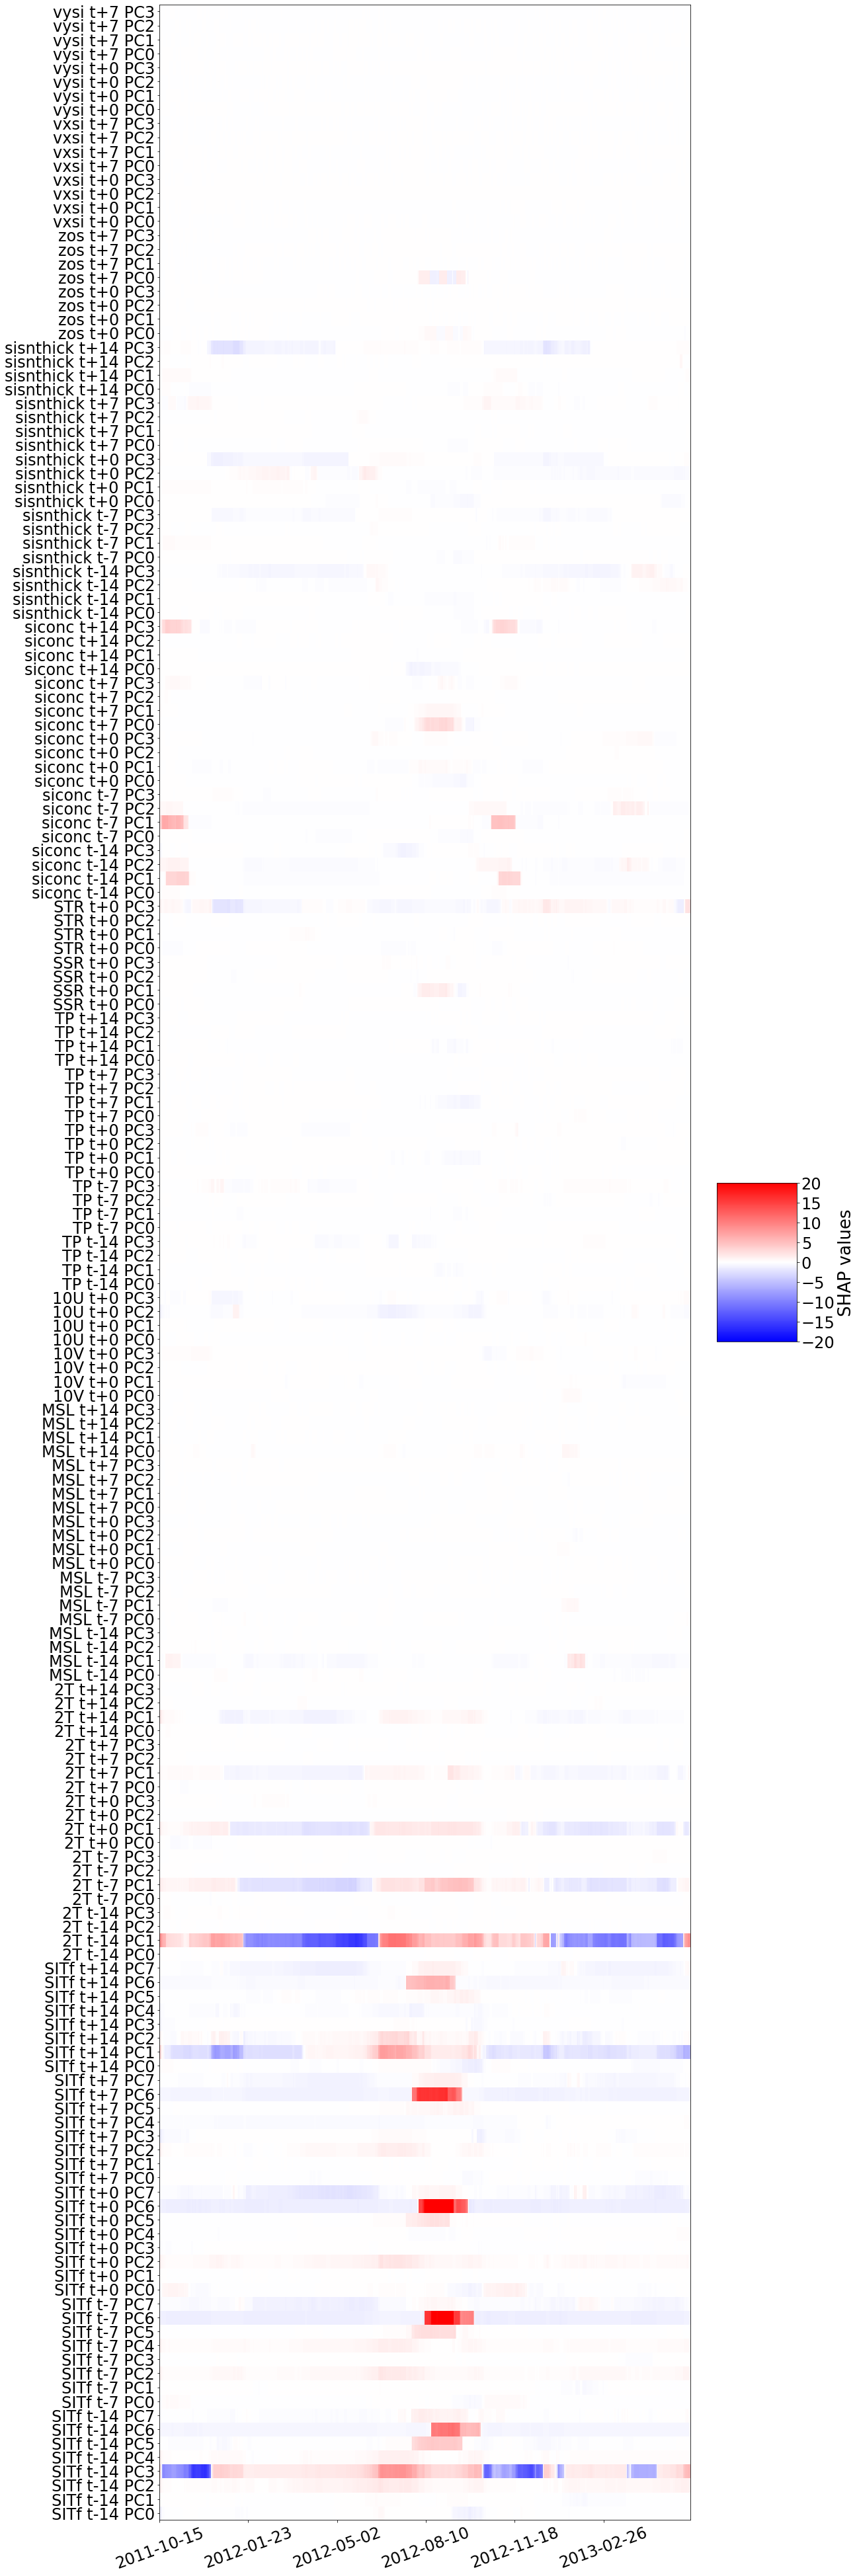

In [25]:
draw_shap_table(shap_values, ds, dates, vmin=-20, vmax=20)